In [950]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
import random
import time

plt.rcParams["figure.figsize"] = (20, 10)

Model: $y = \frac{exp(-b_1*x)}{b_2+b_3*x}  +  e$
exp_beta_1 = 1.6657666537E-01
exp_beta_2 = 5.1653291286E-03
exp_beta_3 = 1.2150007096E-02

In [951]:
func = lambda x, b1, b2, b3: np.e ** (-b1 * x) / (b2 + b3 * x)
minimizing_func = lambda b: np.sum((func(xs, b[0], b[1], b[2]) - ys) ** 2)

const_lr = lambda n, start: start
exp_lr = lambda n, start: start * np.exp(-0.01 * n)

In [952]:
start_point=[2, 4, 5]

In [953]:
exp_beta_1 = 1
exp_beta_2 = 2
exp_beta_3 = 3

xs = np.linspace(0, 5, 100)
ys = func(xs, exp_beta_1, exp_beta_2, exp_beta_3)

In [954]:
def partial(f, i, x):
    h = 1e-5
    x[i] = x[i] + h
    right = f(x)
    x[i] = x[i] - 2 * h
    left = f(x)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad(f, x):
    return [partial(f, i, x) for i in range(len(x))]


def minibatch_grad(func, x, batch):
    return grad(func, x)


def cancel_condition(x):
    return np.linalg.norm(grad(minimizing_func, x)) < 1e-6
    # return minimizing_func(x) < 0.001

def adam(f, b1, b2, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    prev_grad = np.array([0, 0, 0])
    prev_v = np.array([0, 0, 0])
    points = list()
    grads = list()
    loss1 = list()
    points.append(start)
    for i in range(1, epoch):
        gr = np.array(minibatch_grad(f, x, batch))
        grads.append(np.linalg.norm(gr))
        loss1.append(f(x))
        g = b1 * prev_grad + (1 - b1) * gr
        v = b2 * prev_v + (1 - b2) * np.power(gr, 2)
        x = x - lr_strategy(i, lr) * g / np.sqrt(v)
        prev_v = v
        prev_grad = g
        points.append(x)
        if cancel_condition(x):
            break

    return [np.array(points), np.array(grads), np.array(loss1)]

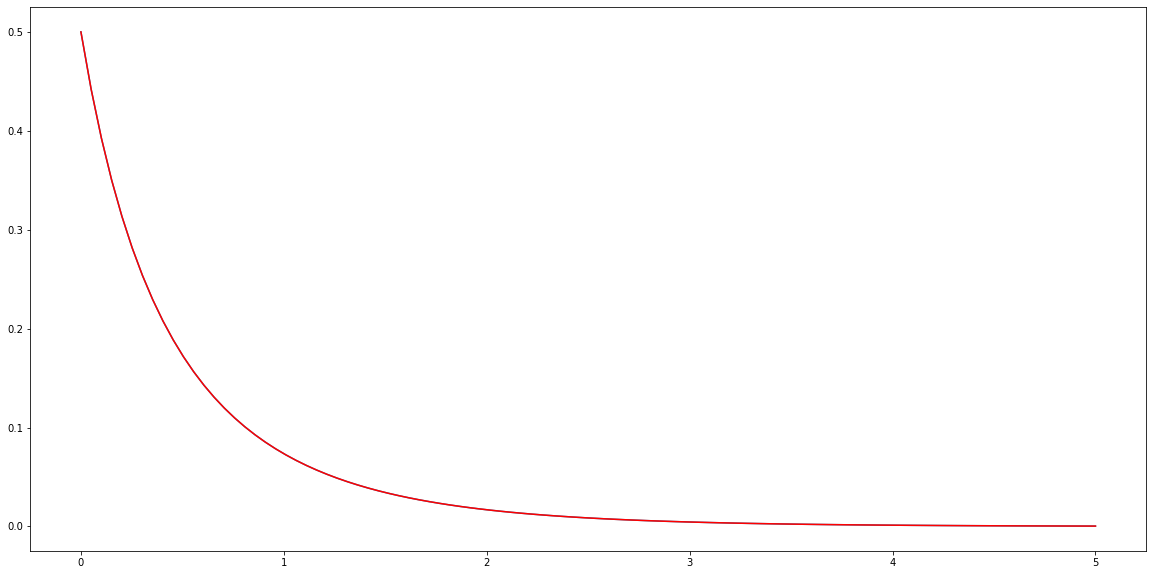

In [955]:
lst = adam(minimizing_func, b1=0.5, b2=0.5, lr=0.2, start=start_point, lr_strategy=exp_lr, epoch=50000,
              batch=30)
points = lst[0]
grads1 = lst[1]
loss1 = lst[2]
ans = points[-1]

plt.plot(xs, func(xs, ans[0], ans[1], ans[2]))

plt.plot(xs, ys, 'r')

In [956]:
len(points)

627


------------------------------------------------------------------

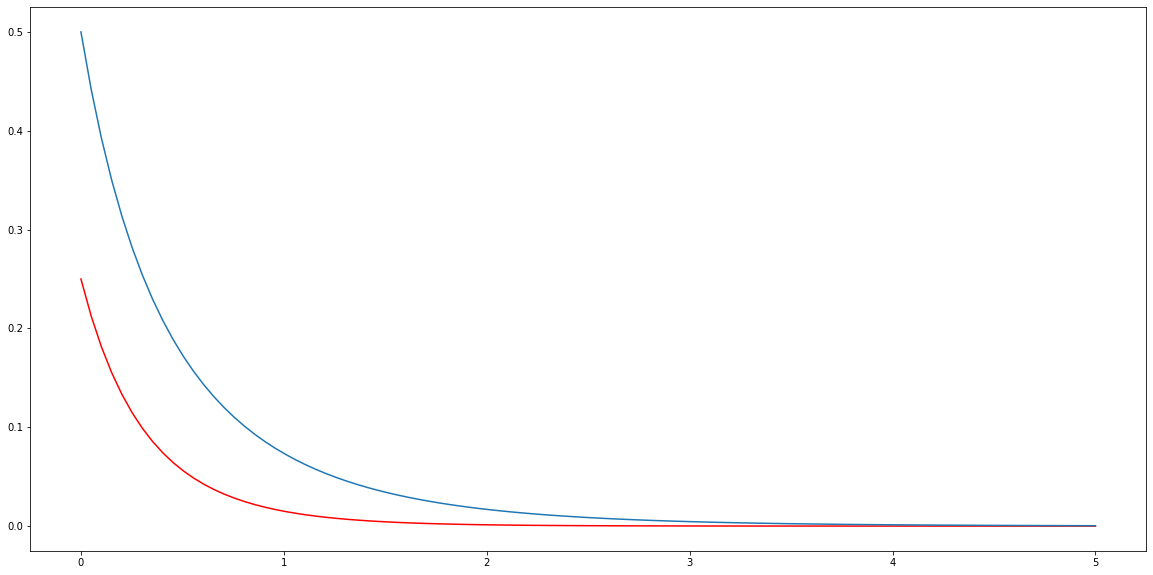

In [957]:

plt.plot(xs, func(xs, *start_point), '-r')
plt.plot(xs, ys)

# plt.plot(x_data, y_data, 'ro')

In [958]:
def cancel_condition2(x):
    return np.linalg.norm(grad(minimizing_func, x)) < 1e-6
    # return minimizing_func2(x, range(100)) < 400


def minimizing_func2(b, idxs=range(100)):
    res = 0
    for i in idxs:
        res += (func(xs[i], b[0], b[1], b[2]) - ys[i]) ** 2
    return res

In [959]:
def partial2(f, i, x, idxs):
    h = 1e-5
    x[i] = x[i] + h
    right = f(x, idxs)
    x[i] = x[i] - 2 * h
    left = f(x, idxs)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad2(f, x, idx_of_term, idx_of_var):
    return partial2(f, idx_of_var, x, idx_of_term)

In [960]:
# p = -(J^T * J)^(-1) J * r


def calcP(x):
    res = list()
    for i in range(3):
        row = list()
        for j in range(100):
            row.append(grad2(minimizing_func2, x, [j], i))
        res.append(row)
    J = np.array(res)
    J = J.transpose()
    JT = J.transpose()
    Mul = np.matmul(JT, J)
    rev = np.linalg.inv(Mul)
    anti = -rev
    hh = np.matmul(anti, JT)
    rs = list()
    for i in range(100):
        rs.append(minimizing_func2(x, [i]))
    rsnp = np.array(rs)
    rstr = rsnp.transpose()
    res = np.matmul(hh, rstr)
    return res


def newton(f, lr, start, lr_strategy=const_lr, epoch=20):
    x = start
    points = list()
    grads = list()
    loss2 = list()
    points.append(start)
    for i in range(1, epoch):
        loss2.append(f(x))
        grads.append(np.linalg.norm(grad(minimizing_func, x)))
        x = x + lr_strategy(i, lr) * np.array(calcP(x))
        points.append(x)
        if cancel_condition2(x):
            break

    return [np.array(points), grads, loss2]

23


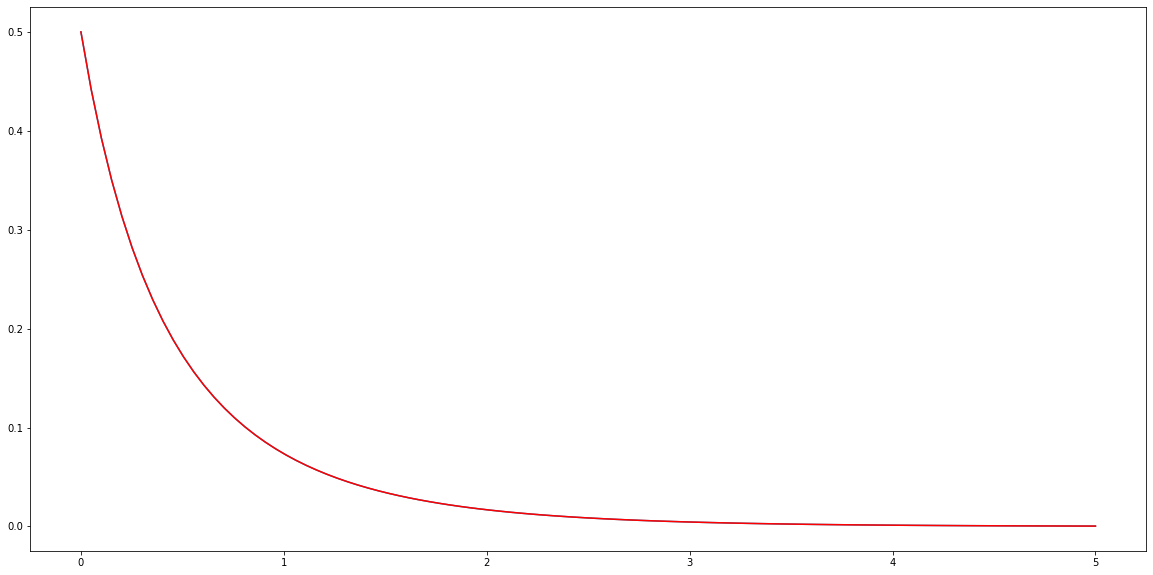

In [961]:
lst = newton(minimizing_func2, 1, start=start_point, lr_strategy=exp_lr, epoch=2000)
points = lst[0]
grads2 = lst[1]
loss2 = lst[2]
print(len(points))

ans = points[-1]
plt.plot(xs, func(xs, ans[0], ans[1], ans[2]), '-')

plt.plot(xs, ys, 'r')

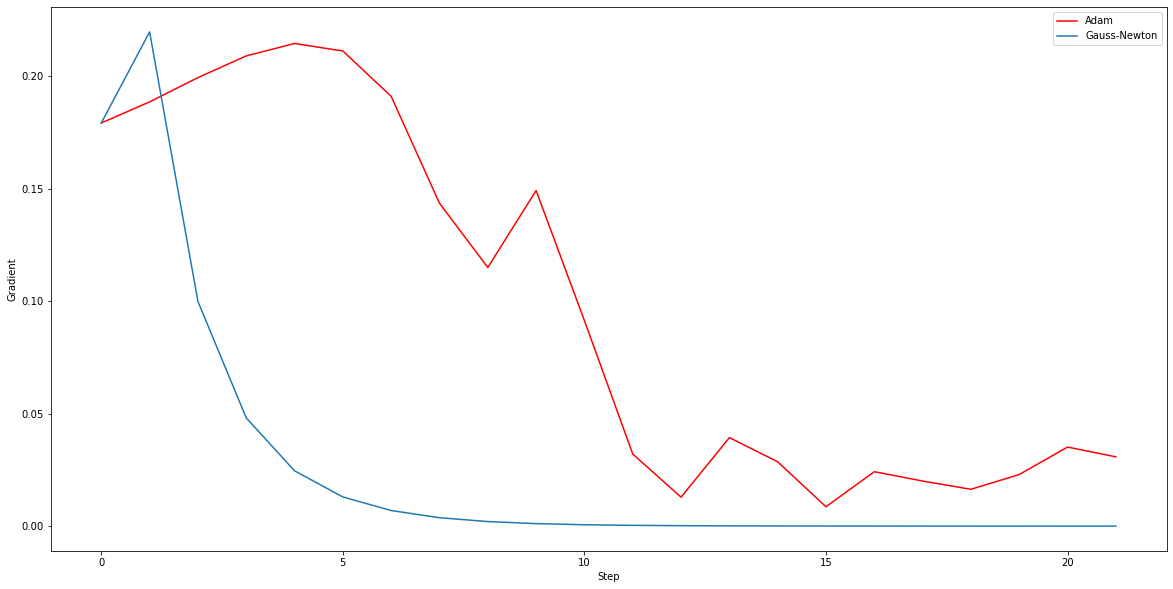

In [962]:



ss = range(0, len(points)-1)

plt.plot(ss, grads1[:len(points)-1], 'r', label='Adam')


plt.plot(ss, grads2[:len(points)-1], label='Gauss-Newton')

plt.xlabel("Step")
plt.ylabel("Gradient")

plt.legend()

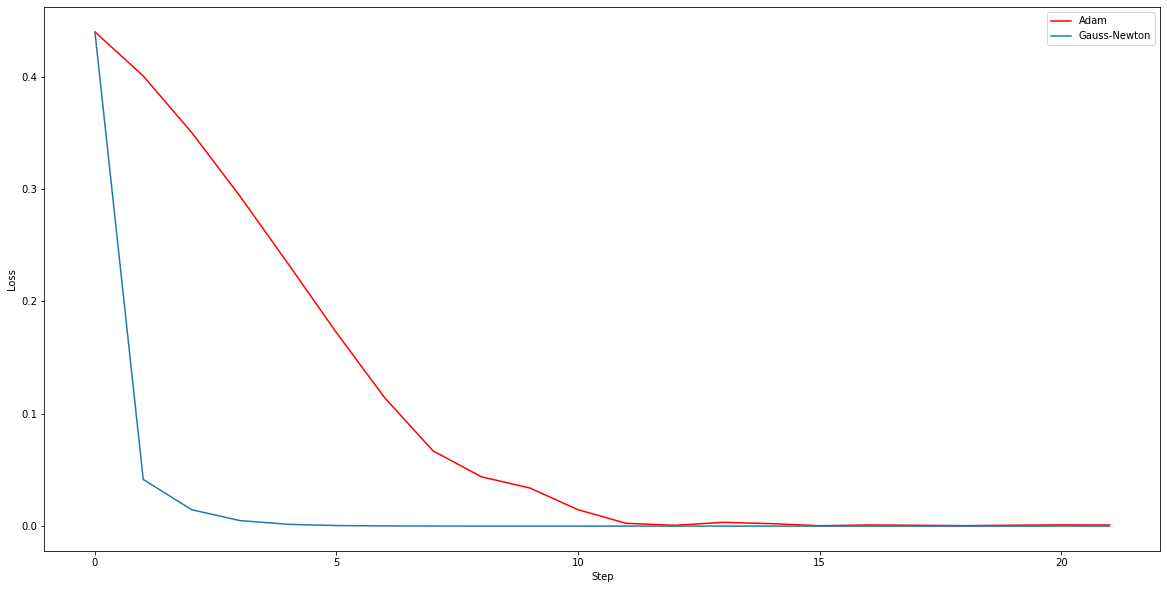

In [963]:
ss = range(0, len(points)-1)

plt.plot(ss, loss1[:len(points)-1], 'r', label='Adam')
plt.plot(ss, loss2[:len(points)-1],  label='Gauss-Newton')

plt.xlabel("Step")
plt.ylabel("Loss")

plt.legend()